In [1]:
import sys
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plot
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
    
# clear any open figures
plot.close('all')
    
# set to show plots
%matplotlib inline

/Users/davidguidos/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# get the data
def get_data(filename):    
    # get data to dataframe
    dataframe = pd.read_csv(filename)
    # eliminate useless rows (all columns missing)
    dataframe.dropna(thresh=1,inplace=True)
    return dataframe

# split data into training and test frames
def split_data(dataframe, feature_fields, target_field, train_size = 0.7, random_state = 1):
    # split into training and test dara frames
    if train_size == 1:
        train_size = dataframe.shape[0]
    train_x, test_x, train_y, test_y = train_test_split(dataframe[feature_fields], 
                                                        dataframe[target_field],
                                                        train_size=train_size, random_state=random_state)    
    return (train_x, train_y, test_x, test_y)

# display the data
def show_data(dataframe, train_x, train_y, test_x, test_y):
    # list the field names
    print('Field Names: ', list(dataframe))

    # show data frame info
    print('\nTraining Data Info:')
    print(train_x.info())
    print('\nField Descriptions:')
    print(train_x.describe())

    # show histogram for the train and test yields
    print(train_y.hist(bins=100))
    print(test_y.hist(bins=100))


In [3]:
# predict data using the model and fill-in the missing row values in the dataframe for the column    
def predict_missing_column_data(df, col, features, model, row_list):
    # continue only if any rows are in the missing row list
    if (len(row_list) > 0):
        # predict the values for the dataframe
        # and create temporary predictions column in the dataframe
        df['predictions'] = model.predict(df[features])
        #print('Model Summary:\n', model.summary())
        #print('Prediction data:\n', df['predictions'])
        # update predicted values for all rows for this column in the row_list
        print('   Updating missing data in ', col, ' with predictions for ', len(row_list), ' rows.')
        for row in row_list:
            df.at[row, col] = df.at[row, 'predictions']
        # remove temporary predictions column
        drop_columns(df, ['predictions'])

# drop columns from a dataframe
def drop_columns(dataframe, drop_list):
    dataframe.drop(drop_list, axis=1, inplace=True)

# get list of all items that need cleaning
def invalid_data(dataframe, data_fields):
    invalid_list = []
    for col, rows in dataframe.iteritems():
        if (col in data_fields):
            row_list = []
            for n, value in rows.iteritems():
                try:
                    if np.isnan(value):
                        row_list.append(n)
                except:
                    e = "isnan not supported for this value type. ignored."
                if value is None:
                    row_list.append(n)
            if len(row_list) > 0:
                invalid_list.append((col, row_list))
    return invalid_list

# auto clean missing data of dataframe by:
#   getting a list of all items to be cleaned
#   processing each column that needs fixing by predicting the values using a regression on that column
#   repeating those steps several times to keep improving the predictions
def auto_clean_data(dataframe, field_names=[], number_of_passes=5, show_progress=True):
    # indicate start
    if (show_progress):
        print('\n\n*********** auto-clean started **********')
    # eliminate useless rows (all columns missing)
    dataframe.dropna(thresh=1,inplace=True)
    # generate list of field names if not specified
    if (field_names == []):
        field_names = list(dataframe)
    # generate list of fields to be cleaned
    invalid_list = invalid_data(dataframe, field_names)
    # start multipass automatic clean
    for n in range(1, number_of_passes + 1):
        if (show_progress):
            print('\n***** starting auto-clean pass ', n, ' *****')
        for col, row_list in invalid_list:
            # clean the fields for this column
            features = field_names.copy()
            # for first pass (n == 1) remove from features any columns which have missing data rows
            # in common with other columns: this will guarantee data for all columns on subsequent passes.
            if (n == 1):
                for i, irows in invalid_list:
                    if (i != col and len(set(row_list) & set(irows)) > 0):
                        features.remove(i)
            train_x = dataframe[features].copy()
            features.remove(col)
            train_x.dropna(inplace=True)
            # set the target of the regression analysis to this column
            clean_train_y = train_x[col]
            clean_train_x = train_x[features]
            # generate the predictive model for this column
            if (show_progress):
                print('Column: ', col, '  Rows to clean: ', len(row_list), '   Training shape: ', clean_train_x.shape)
            try:
                model = sm.OLS(clean_train_y, clean_train_x).fit()
            except:
                print('\nError: ', sys.exc_info()[0])
            else:
                # predict the values for the original dataframe 
                # and create temporary predictions column in the dataframe
                #if (show_progress):
                #    print('Model Summary:\n', model.summary())
                dataframe['predictions'] = model.predict(dataframe[features])
                # update predicted values for all rows for this column in the invalid_list
                for row in row_list:
                    dataframe.at[row, col] = dataframe.at[row, 'predictions']
                # remove temporary predictions column
                drop_columns(dataframe, ['predictions'])                
    if (show_progress):
        print('\n*********** auto-clean completed ***********\n\n\n')


In [4]:
#   super auto clean missing data of dataframe by:
#
#   getting a list of all items to be cleaned
#   processing each column that needs fixing by predicting the values using a regression on that column
#   repeating those steps several times to keep improving the predictions
#
#   dataframe is the main dataframe to clean
#   test_dataframe is an optional dataframe that is cleaned using the same clean model as dataframe; it defaults to empty
#   field_names is a list of dataframe field names to clean-up
#
def super_auto_clean_data(dataframe, field_names=[], test_dataframe=None, number_of_passes=5, show_progress=True):
    # eliminate useless rows (all columns missing)
    dataframe.dropna(thresh=1,inplace=True)
    # generate list of fields to be cleaned
    if (field_names == []):
        field_names = list(dataframe)
    print('Field names: ', field_names)
    # generate list of fields to be cleaned in dataframe and test_dataframe, if specified
    invalid_list = invalid_data(dataframe, field_names)
    invalid_columns = [col for (col, rows) in invalid_list]
    if (test_dataframe != None):
        invalid_list_test = invalid_data(test_dataframe, field_names)
        invalid_columns_test =[col for (col, rows) in invalid_list_test]
        all_invalid_columns = list(set(all_invalid_columns) | set(invalid_list_test.keys()))
    else:
        all_invalid_columns = invalid_columns
    # start multipass automatic clean
    for n in range(1, number_of_passes + 1):
        print('\n\n*********** Starting auto-clean pass ', n, ' ***********\n')
        for col in all_invalid_columns:
            features = field_names.copy()
            # get missing row list for this column
            row_list = [rows for c, rows in invalid_list if c == col][0]
            # clean the fields for this column
            # for first pass (n == 1) remove from features any columns which have missing data rows
            # in common with other columns: this will guarantee data for all columns on subsequent passes.
            if (n == 1):
                for i, irows in invalid_list:
                    if (i != col and len(set(row_list) & set(irows)) > 0):
                        features.remove(i)
            train_x = dataframe[features].copy()
            train_x.dropna(inplace=True)
            # set the target of the regression analysis to this column
            features.remove(col)
            clean_train_x = train_x[features]
            clean_train_y = train_x[col]
            # generate the predictive model for this column
            if (show_progress):
                print('Column: ', col, '  Rows to clean: ', len(row_list), '   Training shape: ', clean_train_x.shape, '\n')
            try:
                model = sm.OLS(clean_train_y, clean_train_x).fit()
            except:
                print('\nError: ', sys.exc_info()[0])
            else:
                # make predictions and replace values
                # replace missing values in the original dataframe with predictions using the model
                try:
                    predict_missing_column_data(dataframe, col, features, model, row_list)
                except:
                    if (show_progress):
                        print('   No missing rows in main dataframe for ', col)

                # replace missing values in the original test dataframe with predictions using the model
                if (test_dataframe != None):
                    try:
                        test_row_list = [rows for c, rows in invalid_list_test if c == col][0]
                        predict_missing_column_data(test_dataframe, col, features, model, test_row_list)
                    except:
                        if (show_progress):
                            print('   No missing rows in test dataframe for ', col)

    print('\n*********** super_auto_clean completed ***********\n\n\n')


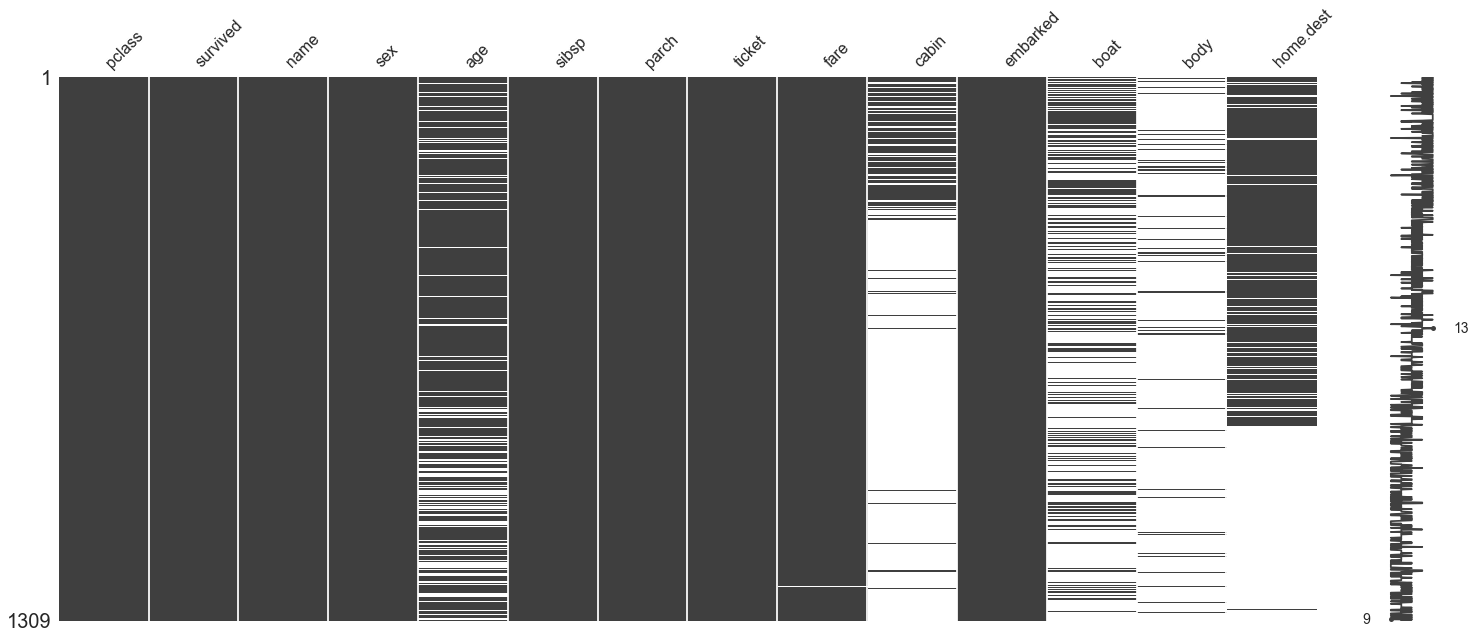



*********** auto-clean started **********

***** starting auto-clean pass  1  *****
Column:  age   Rows to clean:  263    Training shape:  (1045, 5)
Column:  fare   Rows to clean:  1    Training shape:  (120, 6)
Column:  body   Rows to clean:  1188    Training shape:  (121, 5)

***** starting auto-clean pass  2  *****
Column:  age   Rows to clean:  263    Training shape:  (1309, 6)
Column:  fare   Rows to clean:  1    Training shape:  (1309, 6)
Column:  body   Rows to clean:  1188    Training shape:  (1309, 6)

***** starting auto-clean pass  3  *****
Column:  age   Rows to clean:  263    Training shape:  (1309, 6)
Column:  fare   Rows to clean:  1    Training shape:  (1309, 6)
Column:  body   Rows to clean:  1188    Training shape:  (1309, 6)

***** starting auto-clean pass  4  *****
Column:  age   Rows to clean:  263    Training shape:  (1309, 6)
Column:  fare   Rows to clean:  1    Training shape:  (1309, 6)
Column:  body   Rows to clean:  1188    Training shape:  (1309, 6)

*****

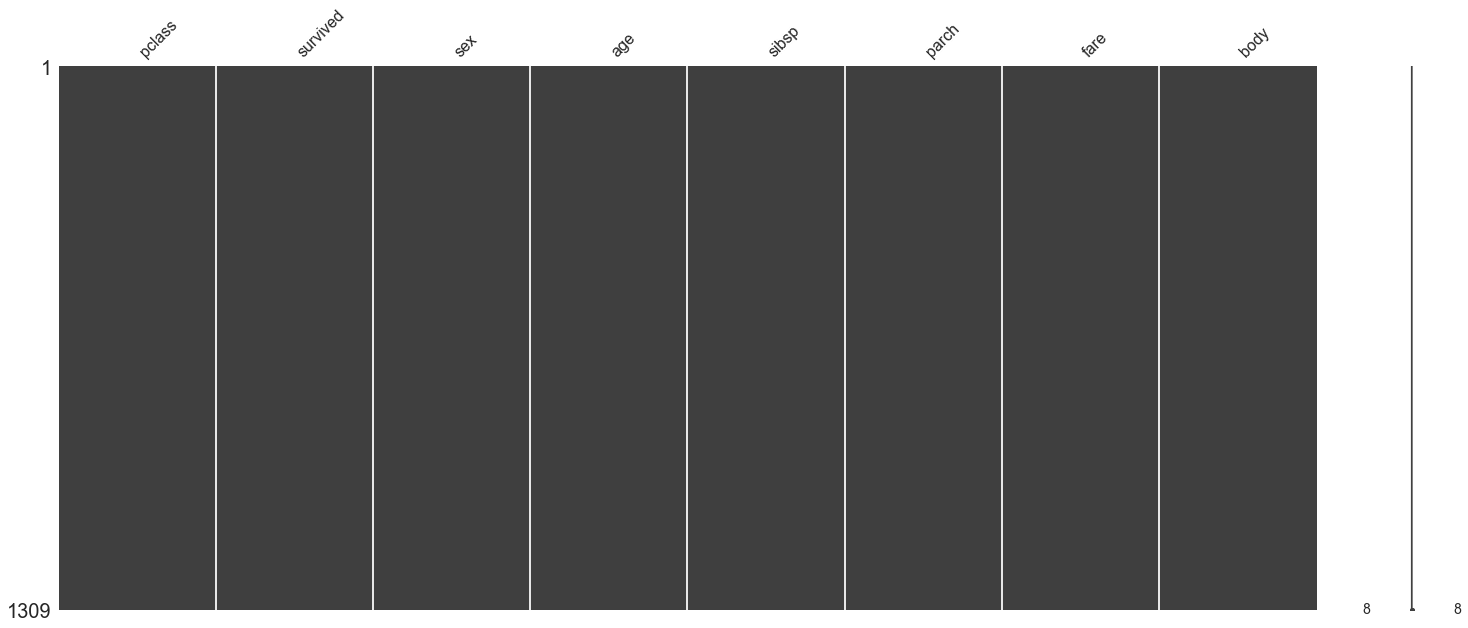

Field Names:  ['pclass', 'survived', 'sex', 'age', 'sibsp', 'parch', 'fare', 'body']

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 916 entries, 306 to 1061
Data columns (total 7 columns):
pclass    916 non-null float64
sex       916 non-null int64
age       916 non-null float64
sibsp     916 non-null float64
parch     916 non-null float64
fare      916 non-null float64
body      916 non-null float64
dtypes: float64(6), int64(1)
memory usage: 57.2 KB
None

Field Descriptions:
           pclass         sex         age       sibsp       parch        fare  \
count  916.000000  916.000000  916.000000  916.000000  916.000000  916.000000   
mean     2.307860    0.650655   29.471155    0.509825    0.373362   33.816862   
std      0.830553    0.477024   13.316215    1.091903    0.823368   53.138375   
min      1.000000    0.000000    0.166700    0.000000    0.000000    0.000000   
25%      2.000000    0.000000   22.000000    0.000000    0.000000    7.895800   
50%      

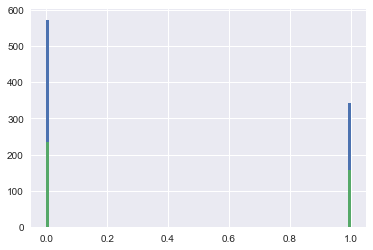

In [5]:
# Titanic Data
#
# get the data and perform the analysis
#
# define drop, feature and target fields
import missingno as msno

all_fields = ['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket', 'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest']
drop_fields = ['name', 'ticket', 'cabin', 'embarked', 'home.dest', 'boat']
feature_fields = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'body']
target_field = 'survived'

# transformations of data unique to this dataset
def transform_data(dataframe):
    dataframe['sex'].replace(['female','male'], [0,1], inplace=True)
    dataframe['boat'].replace(['A','B','C','D'], [17,18,19,20], inplace=True)
    #dataframe.fillna(0, inplace=True)
    #dataframe.dropna()
    
# transformation of data after cleaning   
def transform_data_post(dataframe):
    dataframe.fillna(0, inplace=True)
    dataframe.dropna(inplace=True)

# get the data and show the missing values
df = get_data('titanic_full.csv')
#print(df.boat.unique())
msno.matrix(df)
transform_data(df)
# automatically clean the data by determining the best values for missing data
auto_clean_data(df, feature_fields)
transform_data_post(df)
# remove unused fields from the dataframe
drop_columns(df, drop_fields)
# show the data
print(df)
%matplotlib inline
msno.matrix(df)

# create and train a random forest regressor
# parameters are the dataframes for the features fields and target field 
def random_forest_regressor(features, target):
    clf = RandomForestRegressor()
    clf.fit(features, target)
    return clf

(train_x, train_y, test_x, test_y) = split_data(df, feature_fields, target_field)
show_data(df, train_x, train_y, test_x, test_y)

# train the model
trained_model = random_forest_regressor(train_x, train_y)
print("Trained model :: ", trained_model, '\n')
print("Score: ", trained_model.score(train_x, train_y), '\n')  

     n    n2  square
0    0   0.0     0.0
1    1   2.0     1.0
2    2   NaN     4.0
3    3   6.0     NaN
4    4   NaN     NaN
5    5   NaN    25.0
6    6  12.0    36.0
7    7  14.0    49.0
8    8  16.0    64.0
9    9  18.0    81.0
10  10   NaN   100.0
11  11  22.0     NaN
12  12  24.0   144.0


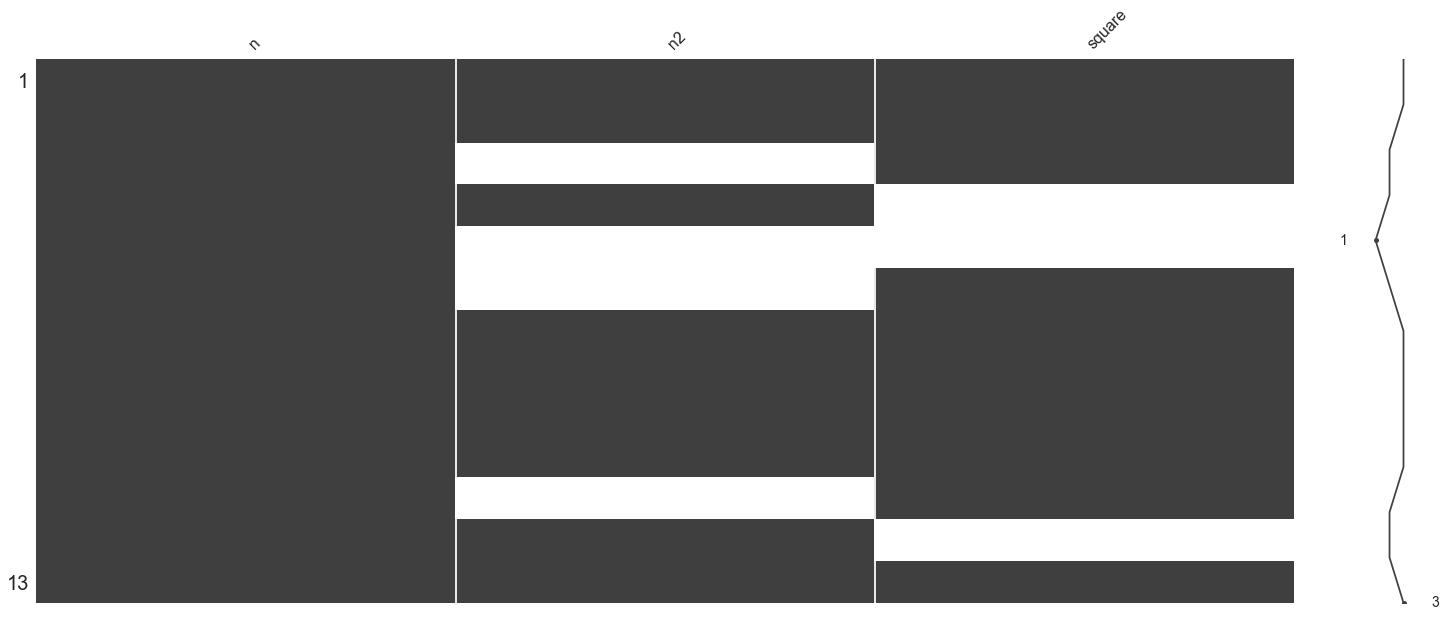



*********** auto-clean started **********

***** starting auto-clean pass  1  *****
Column:  n2   Rows to clean:  4    Training shape:  (9, 1)
Column:  square   Rows to clean:  3    Training shape:  (10, 1)

***** starting auto-clean pass  2  *****
Column:  n2   Rows to clean:  4    Training shape:  (13, 2)
Column:  square   Rows to clean:  3    Training shape:  (13, 2)

***** starting auto-clean pass  3  *****
Column:  n2   Rows to clean:  4    Training shape:  (13, 2)
Column:  square   Rows to clean:  3    Training shape:  (13, 2)

***** starting auto-clean pass  4  *****
Column:  n2   Rows to clean:  4    Training shape:  (13, 2)
Column:  square   Rows to clean:  3    Training shape:  (13, 2)

***** starting auto-clean pass  5  *****
Column:  n2   Rows to clean:  4    Training shape:  (13, 2)
Column:  square   Rows to clean:  3    Training shape:  (13, 2)

*********** auto-clean completed ***********



     n    n2  square
0    0   0.0    0.00
1    1   2.0    1.00
2    2   4.0   

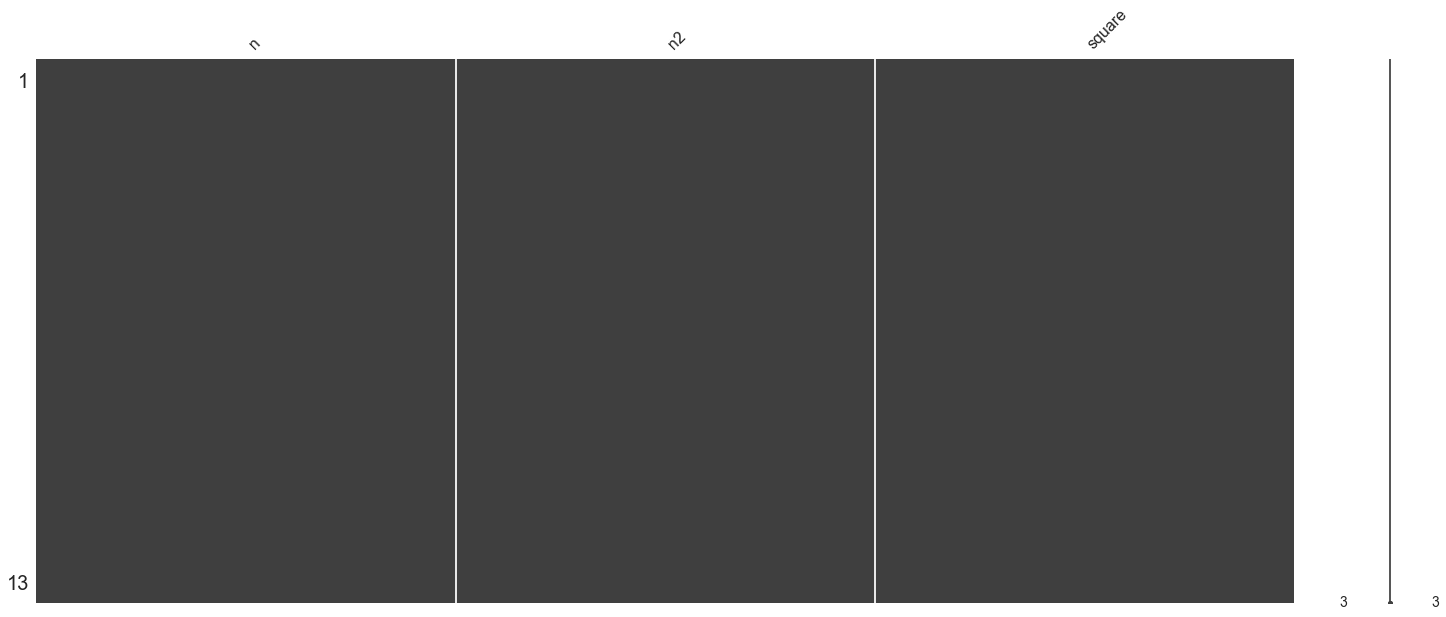

In [6]:
# Simple Data
#
# get the data and perform the analysis
#
# define drop, feature and target fields
import missingno as msno

all_fields = ['n', 'n2', 'square']
drop_fields = []
feature_fields = all_fields
target_field = ''

# get the data and show the missing values
df = get_data('simple_data_incomplete.csv')
print(df)
msno.matrix(df)
# automatically clean the data by determining the best values for missing data
auto_clean_data(df, feature_fields)
# remove unused fields from the dataframe
drop_columns(df, drop_fields)
# show the data
print(df)
%matplotlib inline
msno.matrix(df)
